# **Modeling the mind of a predator: Interactive cognitive maps support flexible avoidance of dynamic threats**

### Toby Wise, Caroline J Charpentier, Peter Dayan & Dean Mobbs

## Analysis notebook 3 - Inverse reinforcement learning models

This notebook contains code for modelling of reward weight estimation using inverse reinforcement learning.

In [13]:
import pandas as pd
import seaborn as sns
import os
import pingouin as pg
import matplotlib.pyplot as plt
from maMDP.env_io import *
from maMDP.env_io import hex_environment_from_dict
import sys
sys.path.append("../../code") 
from utils import load_irl_model_fits
import matplotlib
matplotlib.style.use('toby')
matplotlib.rcParams['font.weight'] = 'normal'
pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams["font.family"] = "Heebo"

## Load in data

In [2]:
rating_dfs = []
rt_dfs = []
confidence_dfs = []
prediction_dfs = []
response_dfs = []

output_dir = '../../data/'
experiment = 'experiment-1'

data_dfs = {'rating_data': rating_dfs, 'rt_data': rt_dfs, 'confidence_data': confidence_dfs, 'prediction_data': prediction_dfs, 'response_data': response_dfs}

for data_type, df_list in data_dfs.items():
    
    data_type_dir = os.path.join(output_dir, data_type, experiment)
    
    conditions = os.listdir(data_type_dir)
    
    for c in conditions:
        for i in os.listdir(os.path.join(data_type_dir, c)):
            if '.csv' in i:
                df = pd.read_csv(os.path.join(data_type_dir, c, i))
                df_list.append(df)

rating_df = pd.concat(rating_dfs)
rt_df = pd.concat(rt_dfs)
confidence_df = pd.concat(confidence_dfs)
prediction_df = pd.concat(prediction_dfs)
response_df = pd.concat(response_dfs)

In [3]:
prediction_df = prediction_df.sort_values(['subjectID', 'exp', 'condition', 'env', 'trial', 'response_number']).reset_index(drop=True)
response_df = response_df.sort_values(['agent', 'subjectID', 'exp', 'condition', 'env', 'trial', 'response_number']).reset_index(drop=True)

## Load environment data

In [4]:
envs = {}
for cond in ['A', 'B', 'C']:
    with open('../../data/game_info/experiment-1/condition_{0}.json'.format(cond), 'r') as f:
        game_info = json.load(f)
    envs[cond] = [hex_environment_from_dict(env, ['Dirt', 'Trees', 'Reward']) for env in game_info['environments']]

### Get predator/prey data

In [5]:
predator_df = response_df[response_df['agent'] == 'predator']
prey_df = response_df[response_df['agent'] == 'prey']
rating_df['feature_index'] = rating_df['feature'].replace({'red': 0, 'trees': 1, 'prey': 2})
rating_df = rating_df[rating_df['env'] == 3]  # This is just used to get subject IDs, so we select one random environment

## Set up parameters to test

This code is largely redundant and basically just creates a list of subject IDs for the fitting script.

The model fitting itself basically performs a grid search procedure using [Inverse Binomial Sampling](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008483), hence the need for a range of parameter values to try out.

In [9]:
# Candidate learning rate decays and learning rates are done in the fitting script - these were originally set here but were since moved, hence the awkward left over code that I never got round to tidying up.
decays = [0]

param_df = pd.DataFrame(decays)
param_df.columns = ['learning_rate_decay']

param_dfs = []

for sub in rating_df['subjectID'].unique():
    sub_param_df = param_df.copy()
    sub_param_df['subjectID'] = sub
    param_dfs.append(sub_param_df)
    
param_dfs = pd.concat(param_dfs)

# param_dfs.to_csv('../../data/IRL_runs.csv', index=False)

## Model fitting

All the inverse reinforcement learning models are fit using the `run_irl_model_fit.py` script in the `~/code` directory. This is fairly computationally intensive, so this procedure is run independently of this notebook to take advantage of HPC parallel computing.

## Load in results of model fitting

In [14]:
observed_weight_df, model_weight_df = load_irl_model_fits('../../data/irl_fits/experiment-1/')

### Plot observed ratings

c:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


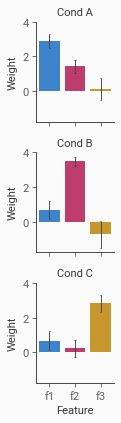

In [11]:
sns.catplot('Feature', 'Weight', data=observed_weight_df, row='condition', kind='bar', height=1.8, aspect=.9, row_order=['A', 'B', 'C'], capsize=.05, errwidth=0.8).set_titles("Cond {row_name}")
plt.tight_layout()

### Combine observed and predicted weights into a single dataframe

In [28]:
model_weight_df = model_weight_df.append(observed_weight_df)
model_weight_df = model_weight_df.replace({'observed': 'Observed'})

### Plot model predictions

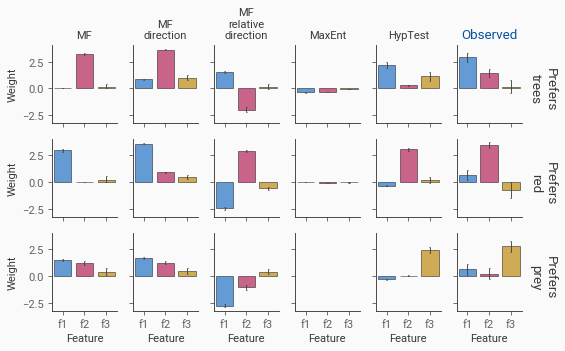

In [79]:
g = sns.catplot(x='Feature', y='Weight', data=model_weight_df, col='model', row='condition', kind='bar', height=1.5, aspect=.8, alpha=0.8,
                col_order=model_weight_df['model'].unique().tolist()[:3] + model_weight_df['model'].unique().tolist()[3:5][::-1] + [model_weight_df['model'].unique().tolist()[-1]], linewidth=.5, edgecolor='black', 
                row_order=['A', 'B', 'C'], capsize=.05, errwidth=0.8).set_titles("{col_name}")
for i in range(3):
    g.axes[i, -1].set_title(g.axes[i, -1].get_title(), fontweight='normal', color='#0752a3')
    if i > 0:
        for j in g.axes[i, :]:
            j.set_title('')
            
g.axes[0, -1].text(3.5, 0, 'Prefers\ntrees', rotation=270, clip_on=False, verticalalignment='center', horizontalalignment='center', fontweight='normal', fontsize=12)
g.axes[1, -1].text(3.5, 0, 'Prefers\nred', rotation=270, clip_on=False, verticalalignment='center', horizontalalignment='center', fontweight='normal', fontsize=12)
g.axes[2, -1].text(3.5, 0, 'Prefers\nprey', rotation=270, clip_on=False, verticalalignment='center', horizontalalignment='center', fontweight='normal', fontsize=12)

plt.tight_layout()
plt.savefig('../../figures/Figure-3_IRL_model_predictions.svg')

### Calculate $R^2$ and BIC


In [29]:
from itertools import product

fit_results['parameters'] = ''

for learning_rate, decay in product(fit_results['max_ent_learning_rate'].unique().tolist(), fit_results['max_ent_learning_rate_decay'].unique().tolist()):
    for model in fit_results['model'].unique():
        fit_results.loc[(fit_results['model'] == model) & (fit_results['max_ent_learning_rate'] == learning_rate) & (fit_results['max_ent_learning_rate_decay'] == decay), 'parameters'] = '{0}_{1}'.format(learning_rate, decay)
        
for condition in ['A', 'B', 'C']:
    for model_id, model in enumerate(fit_results['model'].unique()):
        model_cond_df = fit_results[(fit_results['model'] == model) & (fit_results['condition'] == condition)]
        assert len(model_cond_df['subjectID'].unique()) == 50, 'Condition {0} model {1} missing data'.format(condition, model)
        
fit_results.loc[fit_results['model'] == 'HypTest', 'parameters'] = 1

def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

condition_r2s = {
    'model': [],
    'condition': [],
    'r2': [],
    'adjusted_r2': [],
    'parameters': [],
    'model_id': [],
    'bic': []
}

model_params = {
    'MF': 0,
    'MF_direction': 0,
    'MF_relative_direction': 0,
    'MaxEnt': 2,
    'HypTest': 0
}

for condition in ['A', 'B', 'C']:
    for model_id, model in enumerate(fit_results['model'].unique()):
        
        p = model_params[model]
        
        if model == 'MaxEnt':
            for parameters in fit_results.loc[(fit_results['model'] == model) & (fit_results['condition'] == condition), 'parameters'].unique():
                true = fit_results.loc[(fit_results['model'] == model) & (fit_results['condition'] == condition) & (fit_results['parameters'] == parameters), ['f1_true', 'f2_true', 'f3_true']].values.flatten()
                pred = fit_results.loc[(fit_results['model'] == model) & (fit_results['condition'] == condition) & (fit_results['parameters'] == parameters), ['f1', 'f2', 'f3']].values.flatten()
                
                # MaxEnt values are invalid for condition C
                if model == 'MaxEnt' and condition == 'C':
                    r2 = np.nan
                else:
                    r2 = r2_score(true, pred)
                n = len(true)         
                bic = len(true) * np.log(np.square(np.abs(true - pred)).sum() / len(true)) + p * np.log(len(true))

                condition_r2s['parameters'].append(parameters)
                condition_r2s['model'].append(model.replace('_', '\n'))
                condition_r2s['model_id'].append(model_id)
                condition_r2s['condition'].append(condition)
                condition_r2s['r2'].append(r2)
                condition_r2s['adjusted_r2'].append(adjusted_r2(r2, n, p))
                condition_r2s['bic'].append(bic)
                
        else:
            true = fit_results.loc[(fit_results['model'] == model) & (fit_results['condition'] == condition), ['f1_true', 'f2_true', 'f3_true']].values.flatten()
            pred =  fit_results.loc[(fit_results['model'] == model) & (fit_results['condition'] == condition), ['f1', 'f2', 'f3']].values.flatten()
            
            r2 = r2_score(true, pred)
            n = len(true)
            bic = len(true) * np.log(np.square(np.abs(true - pred)).sum() / len(true)) + p * np.log(len(true))
            
            condition_r2s['parameters'].append('NA')
            condition_r2s['model'].append(model.replace('_', '\n'))
            condition_r2s['model_id'].append(model_id)
            condition_r2s['condition'].append(condition)
            condition_r2s['r2'].append(r2)
            condition_r2s['adjusted_r2'].append(adjusted_r2(r2, n, p)) 
            condition_r2s['bic'].append(bic)

condition_r2s = pd.DataFrame(condition_r2s)

condition_r2s['condition_label'] = condition_r2s['condition']
condition_r2s.loc[condition_r2s['condition'] == 'A', 'condition_label'] = condition_r2s.loc[condition_r2s['condition'] == 'A', 'condition_label'] + '\n(prefers trees)'
condition_r2s.loc[condition_r2s['condition'] == 'B', 'condition_label'] = condition_r2s.loc[condition_r2s['condition'] == 'B', 'condition_label'] + '\n(prefers red)'
condition_r2s.loc[condition_r2s['condition'] == 'C', 'condition_label'] = condition_r2s.loc[condition_r2s['condition'] == 'C', 'condition_label'] + '\n(prefers prey)'

In [35]:
condition_r2s.groupby('model').mean()

,r2,adjusted_r2,model_id,bic
model,,,,
HypTest,0.090129,0.090129,3.0,232.980025
MF,-0.492362,-0.492362,0.0,308.972538
MF\ndirection,-0.401438,-0.401438,1.0,299.718385
MF\nrelative\ndirection,-0.692765,-0.692765,2.0,320.266313
MaxEnt,-0.520590,-0.541279,4.0,322.669276


### Plot BIC across fits

C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


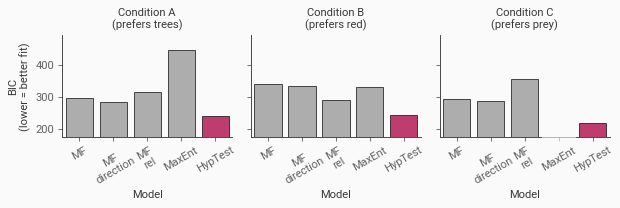

In [54]:
pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
colours = np.array(['#adadad'] * 5)
colours[-1] = pal[1]

plot_bics = condition_r2s.groupby(['model', 'condition_label']).max().reset_index().sort_values('model_id').replace({'MF\nrelative\ndirection': 'MF\nrel'})

g = sns.catplot('model', 'bic', data=plot_bics, col='condition_label', linewidth=.6, edgecolor='black',
            order=model_weight_df['model'].replace({'MF\nrelative\ndirection': 'MF\nrel'}).unique().tolist()[:3] + 
                model_weight_df['model'].replace({'MF\nrelative\ndirection': 'MF\nrel'}).unique().tolist()[3:5][::-1], 
            height=2.7, aspect=.97, kind='bar', palette=colours, alpha=1).set(ylabel='BIC\n(lower = better fit)', xlabel='Model').set_titles('Condition {col_name}')
g.set_xticklabels(rotation=30)
g.set(ylim=(plot_bics['bic'].min() - (plot_bics['bic'].max() - plot_bics['bic'].min()) / 5, 
                          plot_bics['bic'].max() + (plot_bics['bic'].max() - plot_bics['bic'].min()) / 5))
   
import matplotlib.patches as patches
rect = patches.Rectangle((2.5, 160), 1, 25, linewidth=1, edgecolor='none', facecolor='#fbfbfb', clip_on=False, alpha=.6, zorder=5)
g.axes[0][-1].add_patch(rect)
    

plt.tight_layout()
plt.savefig('../../figures/Figure-3_IRL_BIC.svg')

### Look at model predictions across all environments

Here we load in model fits and subject predictions for environments _up to_ 1-4 (i.e., models trained on all environments observed so far, and subjects' predictions based on the same).

In [45]:
observed_dfs = []
model_dfs = []

for env in range(1, 5):
    obs, model = load_irl_model_fits('../../data/irl_fits/experiment-1/env_{}'.format(env))
    obs['env'] = env
    model['env'] = env
    observed_dfs.append(obs)
    model_dfs.append(model)

observed_dfs = pd.concat(observed_dfs)
model_dfs = pd.concat(model_dfs)
model_dfs = model_dfs[model_dfs['model'] == 'HypTest']

# combine observed and model data
combined_df = pd.concat([observed_dfs, model_dfs])

<Figure size 480x320 with 0 Axes>

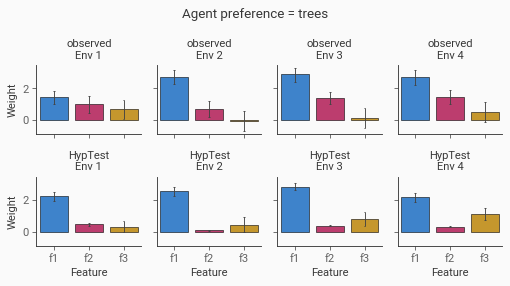

In [48]:
sns.catplot(
    x="Feature",
    y="Weight",
    data=combined_df[combined_df['condition'] == 'A'],
    row="model",
    col='env',
    kind="bar",
    height=1.8,
    aspect=0.9,
    capsize=0.05,
    errwidth=0.8,
    linewidth=.5, 
    edgecolor='black', 
).set_titles("{row_name}\nEnv {col_name}")
plt.suptitle('Agent preference = trees')
plt.tight_layout()

plt.savefig('../../figures/IRL_fit_all_envs_cond-A.svg')


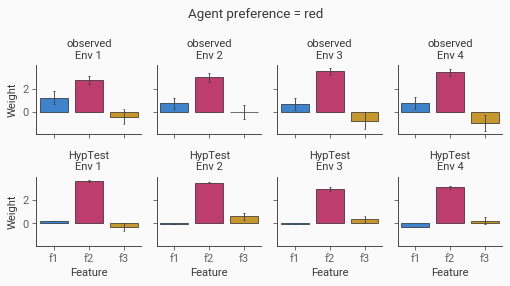

In [49]:
sns.catplot(
    x="Feature",
    y="Weight",
    data=combined_df[combined_df['condition'] == 'B'],
    row="model",
    col='env',
    kind="bar",
    height=1.8,
    aspect=0.9,
    capsize=0.05,
    errwidth=0.8,
    linewidth=.5, 
    edgecolor='black', 
).set_titles("{row_name}\nEnv {col_name}")
plt.suptitle('Agent preference = red')
plt.tight_layout()

plt.savefig('../../figures/IRL_fit_all_envs_cond-B.svg')


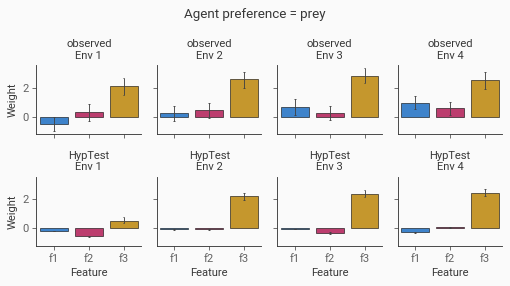

In [50]:
sns.catplot(
    x="Feature",
    y="Weight",
    data=combined_df[combined_df['condition'] == 'C'],
    row="model",
    col='env',
    kind="bar",
    height=1.8,
    aspect=0.9,
    capsize=0.05,
    errwidth=0.8,
    linewidth=.5, 
    edgecolor='black', 
).set_titles("{row_name}\nEnv {col_name}")
plt.suptitle('Agent preference = prey')
plt.tight_layout()

plt.savefig('../../figures/IRL_fit_all_envs_cond-C.svg')
